Automatic differentiation using JAX is a powerful tool for conducting high-dimensional data analysis. This tutorial demonstrates how automatic differentiation may be leveraged for structure refinement.

The numerical experiment performed here can be described in 3 steps:

1. Simulate a synthetic dataset of a protein in a "ground truth" conformation 
2. Define a image simulation model using a different conformation
3. Recover the ground truth by optimising the atom positions using gradient descent.

We will use thyroglobulin for this example, using structures modified from the Flatiron Institute cryo-EM conformational heterogeneity challenge.

*References:*

- Astore, Miro A., et al. "The Inaugural Flatiron Institute Cryo-EM Conformational Heterogeneity Challenge." bioRxiv (2025): 2025-07.

We will start by simulating a synthetic dataset.

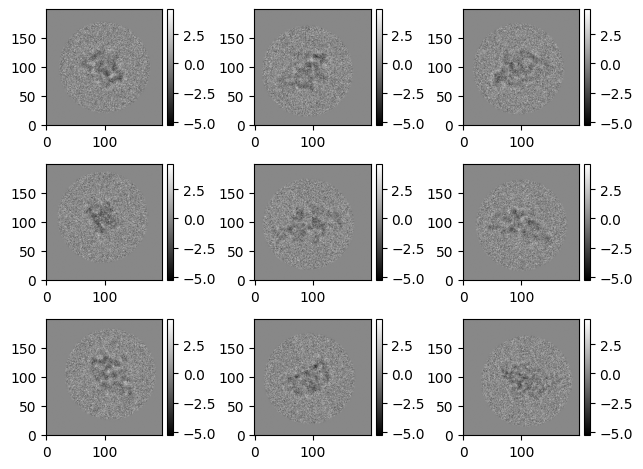

In [1]:
# Imports for dataset generation
import math

import equinox as eqx
import jax
import jax.numpy as jnp
from jaxtyping import Array, PRNGKeyArray
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cryojax.simulator as cxs
from cryojax.io import read_atoms_from_pdb
from cryojax.ndimage import transforms as tf
from cryojax.rotations import SO3


def plot_image_stack(images, cmap="gray", **kwargs):
    """Plot an image stack"""
    n_images_per_side = int(math.sqrt(images.shape[0]))
    fig, axes = plt.subplots(nrows=n_images_per_side, ncols=n_images_per_side)
    vmin, vmax = images.min(), images.max()
    for idx, ax in enumerate(axes.ravel()):
        im = ax.imshow(
            images[idx], cmap=cmap, vmin=vmin, vmax=vmax, origin="lower", **kwargs
        )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)
    fig.tight_layout()


# Dataset generation parameters
N_PARTICLES = 200
SIMULATE_RNG_SEED = 1234
SNR = 0.1
DEFOCUS_RANGE = (5000, 15000)
SPHERICAL_ABERRATION_IN_MM = 2.7
AMPLITUDE_CONTRAST_RATIO = 0.1
PIXEL_SIZE = 2.0
VOLTAGE_IN_KILOVOLTS = 300.0
IMAGE_DIM = 200
PAD_SCALE = 1.5
GMM_WIDTH_IN_ANGSTROMS = 3.0


def make_parameters(
    rng_key: PRNGKeyArray, image_config: cxs.BasicImageConfig
) -> tuple[cxs.EulerAnglePose, cxs.ContrastTransferTheory]:
    """Generate random pose and CTF parameters"""
    key, subkey = jax.random.split(rng_key)
    rotation = SO3.sample_uniform(subkey)
    ny, nx = image_config.shape
    key, subkey = jax.random.split(key)
    offset_in_angstroms = (
        jax.random.uniform(subkey, (2,), minval=-0.1, maxval=0.1)
        * jnp.asarray((nx, ny))
        / 2
        * image_config.pixel_size
    )
    pose = cxs.EulerAnglePose.from_rotation_and_translation(rotation, offset_in_angstroms)
    key, subkey = jax.random.split(key)
    defocus_in_angstroms = jax.random.uniform(
        subkey, (), minval=DEFOCUS_RANGE[0], maxval=DEFOCUS_RANGE[1], dtype=float
    )
    transfer_theory = cxs.ContrastTransferTheory(
        ctf=cxs.AstigmaticCTF(
            defocus_in_angstroms=defocus_in_angstroms,
            spherical_aberration_in_mm=SPHERICAL_ABERRATION_IN_MM,
        ),
        amplitude_contrast_ratio=AMPLITUDE_CONTRAST_RATIO,
    )

    return pose, transfer_theory


@eqx.filter_jit
@eqx.filter_vmap(in_axes=(0, None, None))
def simulate_dataset(
    rng_key: PRNGKeyArray,
    volume: cxs.GaussianMixtureVolume,
    image_config: cxs.BasicImageConfig,
) -> tuple[Array, dict, tf.CircularCosineMask]:
    """Simulate a synthetic dataset"""
    particle_rng_key, noise_rng_key = jax.random.split(rng_key, num=2)
    pose, transfer_theory = make_parameters(particle_rng_key, image_config)
    circular_mask = tf.CircularCosineMask(
        image_config.coordinate_grid_in_angstroms,
        radius=150.0,
        rolloff_width=10.0,
        xy_offset=pose.offset_in_angstroms,
    )
    image_model = cxs.make_image_model(
        volume,
        image_config,
        pose,
        transfer_theory,
        normalizes_signal=True,
        signal_region=circular_mask.array == 1.0,
    )
    noise_model = cxs.UncorrelatedGaussianNoiseModel(
        image_model, variance=1.0, signal_scale_factor=jnp.sqrt(SNR)
    )
    parameters = dict(
        pose=pose, transfer_theory=transfer_theory, image_config=image_config
    )

    return (
        noise_model.sample(noise_rng_key, mask=circular_mask),
        parameters,
        circular_mask,
    )


# Load gaussian mixture. For simplicity, simulate using only C-alphas
ground_truth_positions, _ = read_atoms_from_pdb(
    "./data/thyroglobulin_target.pdb",
    selection_string="name CA",
)
n_atoms = ground_truth_positions.shape[0]
volume = cxs.GaussianMixtureVolume(
    ground_truth_positions,
    amplitudes=jnp.full((n_atoms, 1), 1.0),
    variances=jnp.full((n_atoms, 1), GMM_WIDTH_IN_ANGSTROMS**2),
)
# Instantiate `image_config`
padded_dim = int(PAD_SCALE * IMAGE_DIM)
pad_options = dict(shape=(padded_dim, padded_dim))
image_config = cxs.BasicImageConfig(
    shape=(IMAGE_DIM, IMAGE_DIM),
    pixel_size=PIXEL_SIZE,
    voltage_in_kilovolts=VOLTAGE_IN_KILOVOLTS,
    pad_options=pad_options,
)
# Create RNG keys and simulate
rng_keys = jax.random.split(jax.random.key(SIMULATE_RNG_SEED), num=N_PARTICLES)
dataset_images, dataset_parameters, masks = simulate_dataset(
    rng_keys, volume, image_config
)
plot_image_stack(dataset_images[0:9])

Next, define the loss function. We will naively do a gradient descent on the positions of the C-alpha atoms to see if we can capture the large-scale difference of the conformational change.

In [ ]:
@eqx.filter_value_and_grad
def compute_loss(atom_positions, args):
    """Cross-corrlelation loss over a batch of images"""

    @eqx.filter_vmap(in_axes=(None, eqx.if_array(0)))
    def compute_loss_per_particle(atom_positions, args):
        (image, particle_parameters, mask) = args
        volume = cxs.GaussianMixtureVolume(
            atom_positions,
            amplitudes=1.0,
            variances=GMM_WIDTH_IN_ANGSTROMS**2,
        )
        image_model = cxs.make_image_model(
            volume,
            image_config=particle_parameters["image_config"],
            pose=particle_parameters["pose"],
            transfer_theory=particle_parameters["transfer_theory"],
            normalizes_signal=True,
            signal_region=mask.array == 1.0,
        )
        return -jnp.sum(image_model.simulate(mask=mask) * image)

    return jnp.sum(compute_loss_per_particle(atom_positions, args))

Finally, perform the gradient descent. To do so, we will implement a *stochastic gradient descent*, choosing random subsets of the dataset for each gradient step. This will require defining what is called a dataloader, which allows us to loop through these random subsets.

We will do this in a naive way, but to learn about dataloaders in general see [pytorch's implementation](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#datasets-dataloaders). At the time of writing this the JAX ecosystem has a dataloader library in development called [grain](https://github.com/google/grain).

step=0, loss=-85915.3046875
step=10, loss=-107056.9765625
step=20, loss=-111122.5390625
step=30, loss=-112066.921875
step=40, loss=-112294.625
step=50, loss=-112583.03125
step=60, loss=-113348.7421875
step=70, loss=-112660.3828125
step=80, loss=-113082.6953125
step=90, loss=-112896.0078125
step=99, loss=-111097.7109375


[Text(0.5, 0, 'step number'), Text(0, 0.5, 'cross-correlation loss')]

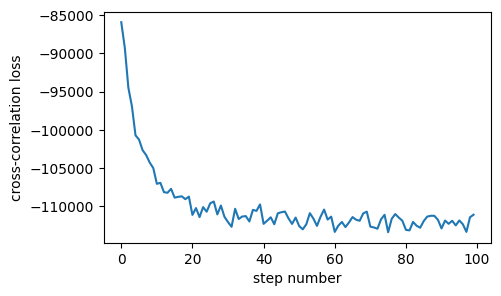

In [3]:
import numpy as np
import optax

from cryojax.dataset import AbstractDataset


class PyTreeDataset(AbstractDataset):
    """Dataset as an arbitrary in-memory PyTree, where all arrays
    have a batch dimension.
    """

    def __init__(self, pytree):
        self.pytree_dynamic, self.pytree_static = eqx.partition(pytree, eqx.is_array)
        assert all(
            arr.shape[0] == len(self) for arr in jax.tree.leaves(self.pytree_dynamic)
        )

    def __getitem__(self, index):
        return eqx.combine(
            jax.tree.map(lambda x: x[index], self.pytree_dynamic), self.pytree_static
        )

    def __len__(self) -> int:
        return jax.tree.leaves(self.pytree_dynamic)[0].shape[0]


def dataloader(dataset, batch_size):
    """A simple dataloader that splits the dataset into
    random subsets of size `batch_size`.
    """
    dataset_size = len(dataset)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield dataset[batch_perm]
            start = end
            end = start + batch_size


# Optimisation parameters
BATCH_SIZE = 20
NUM_STEPS = 100
PRINT_EVERY = 10
OPTIM = optax.adabelief(learning_rate=0.5, nesterov=True)


# Wrap everything into a single JIT region
@eqx.filter_jit(donate="all")
def make_step(atom_positions, opt_state, args):
    loss, grads = compute_loss(atom_positions, args)
    updates, opt_state = OPTIM.update(grads, opt_state)
    atom_positions = eqx.apply_updates(atom_positions, updates)
    return loss, atom_positions, opt_state


# Initialize optimisation using different conformation
initial_positions, _ = read_atoms_from_pdb(
    "./data/thyroglobulin_initial.pdb", selection_string="name CA"
)

# Run optimisation
pytree = (dataset_images, dataset_parameters, masks)
dataset = PyTreeDataset(pytree)
opt_positions, opt_state, loss_values = (
    initial_positions,
    OPTIM.init(initial_positions),
    [],
)
for step, data_batch in zip(range(NUM_STEPS), dataloader(dataset, BATCH_SIZE)):
    loss, opt_positions, opt_state = make_step(opt_positions, opt_state, data_batch)
    loss_values.append(loss.item())
    if step % PRINT_EVERY == 0 or step in [0, NUM_STEPS - 1]:
        print(f"step={step}, loss={loss.item()}")

fig, ax = plt.figure(figsize=(5, 3)), plt.gca()
ax.plot(range(NUM_STEPS), loss_values)
ax.set(xlabel="step number", ylabel="cross-correlation loss")

Now let's check the results! Let's first look at FSC curves between the ground truth and structure before and after refinement.

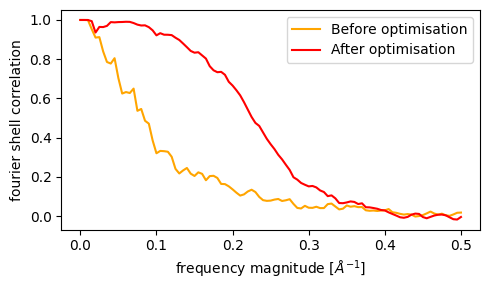

In [ ]:
from cryojax.coordinates import make_radial_frequency_grid
from cryojax.ndimage import compute_fourier_shell_correlation, rfftn


def plot_fsc(pos1, pos2, ax, **kwargs):
    shape, voxel_size = (IMAGE_DIM, IMAGE_DIM, IMAGE_DIM), PIXEL_SIZE
    compute_voxels = lambda pos: cxs.GaussianMixtureVolume(
        pos,
        amplitudes=1.0,
        variances=GMM_WIDTH_IN_ANGSTROMS**2,
    ).to_real_voxel_grid(shape, voxel_size)
    voxels1 = rfftn(compute_voxels(pos1))
    voxels2 = rfftn(compute_voxels(pos2))
    frequencies = make_radial_frequency_grid(shape)
    fsc, frequency_bins, _ = compute_fourier_shell_correlation(
        voxels1,
        voxels2,
        frequencies,
        maximum_frequency=0.5,
    )
    ax.plot(frequency_bins, fsc, **kwargs)


fig, ax = plt.figure(figsize=(5, 3)), plt.gca()
plot_fsc(
    ground_truth_positions,
    initial_positions,
    ax,
    label="Before optimisation",
    color="orange",
)
plot_fsc(
    ground_truth_positions, opt_positions, ax, label="After optimisation", color="red"
)
ax.set(xlabel=r"frequency magnitude [$\AA^{-1}$]", ylabel="fourier shell correlation")
ax.legend()
plt.tight_layout()

The above FSC curves quantifies the increase in correlation after gradient descent refinement. Indeed, visually the refinement is able to (roughly) recover the ground truth conformation!

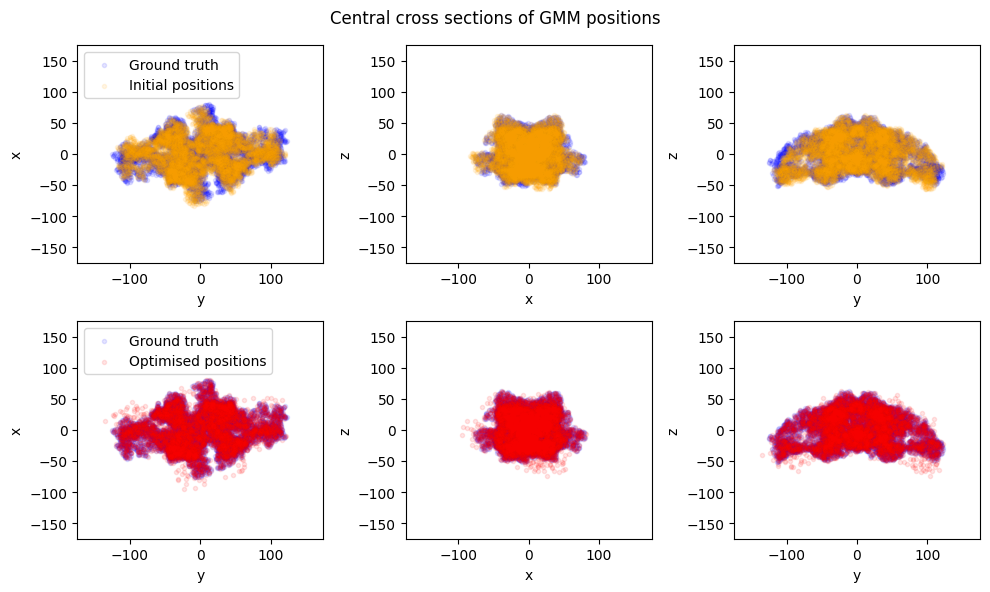

In [5]:
def plot_cross_sections(
    pos1, pos2, axes, label1=None, label2=None, color1="b", color2="orange"
):
    kwargs = dict(marker=".", alpha=0.1)
    xlim, ylim = (-175, 175), (-175, 175)
    for pos, label, color in zip((pos1, pos2), (label1, label2), (color1, color2)):
        axes[0].scatter(pos[:, 1], pos[:, 0], c=color, label=label, **kwargs)
        axes[0].set(xlabel="y", ylabel="x", xlim=xlim, ylim=ylim)
        axes[1].scatter(pos[:, 0], pos[:, 2], c=color, **kwargs)
        axes[1].set(xlabel="x", ylabel="z", xlim=xlim, ylim=ylim)
        axes[2].scatter(pos[:, 1], pos[:, 2], c=color, **kwargs)
        axes[2].set(xlabel="y", ylabel="z", xlim=xlim, ylim=ylim)
    axes[0].legend(loc="upper left")

    return fig, axes


fig, axes = plt.subplots(figsize=(10, 6), ncols=3, nrows=2)
plot_cross_sections(
    ground_truth_positions,
    initial_positions,
    axes=axes[0, :],
    label1="Ground truth",
    label2="Initial positions",
    color2="orange",
)
plot_cross_sections(
    ground_truth_positions,
    opt_positions,
    axes=axes[1, :],
    label1="Ground truth",
    label2="Optimised positions",
    color2="red",
)
fig.suptitle("Central cross sections of GMM positions")
plt.tight_layout()